# Hack&Roll 2025 submission
## Online Meeting Assistant

### This is a project that implements facial emotion recognition with environmental sensors.

Datasets used:
[FER2013](https://www.kaggle.com/datasets/msambare/fer2013)

Make sure you have Python installed. 

To install dependencies, run the following in your PowerShell (Windows) or Terminal (Mac)

```console 
pip install -r requirements.txt
``` 

For the Raspberry Pi code, install the dependencies using the following command on the Raspberry Pi Terminal

```console 
pip install -r rpi_requirements.txt
``` 

### Step 1: Set Up Libraries and Data

In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


### Check for CUDA Availability

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Step 2: Define Model Architecture
Use a pretrained model as a starting point, such as resnet18 from PyTorch’s model zoo. You can modify the final layer to match the number of emotion classes.

In [3]:
import torch
import torch.nn as nn
from torchvision import models

# Load pre-trained model and modify for the number of emotion classes
num_classes = 5
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify final layer

c:\Users\chong\OneDrive\Desktop\Git Repositories\Hack-Roll2025\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chong\OneDrive\Desktop\Git Repositories\Hack-Roll2025\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Step 3: Load data
Load training and testing datasets

In [4]:
# Original dataset
original_dataset1 = './fer/original'

# Training dataset
train_dataset1 = './fer/train'

# Testing dataset
test_dataset1 = './fer/test'

In [5]:
import os
import matplotlib.pyplot as plt

def count_images_in_folders(dataset_path):
    emotion_counts = {}
    
    # Iterate over each emotion folder
    for emotion_folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, emotion_folder)
        if os.path.isdir(folder_path):
            # Count images in each emotion folder
            num_images = len([file for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))])
            emotion_counts[emotion_folder] = num_images

    return emotion_counts

# Count images in each dataset
original_counts1 = count_images_in_folders(original_dataset1)
train1_counts = count_images_in_folders(train_dataset1)
test1_counts = count_images_in_folders(test_dataset1)

print("Dataset1 total number of images: ", sum(train1_counts.values()) + sum(test1_counts.values()))

Dataset1 total number of images:  30219


Plotting the number of images per emotion on each dataset

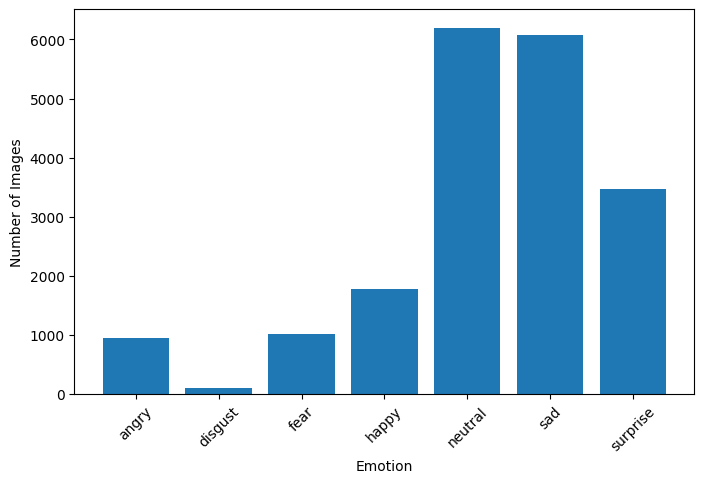

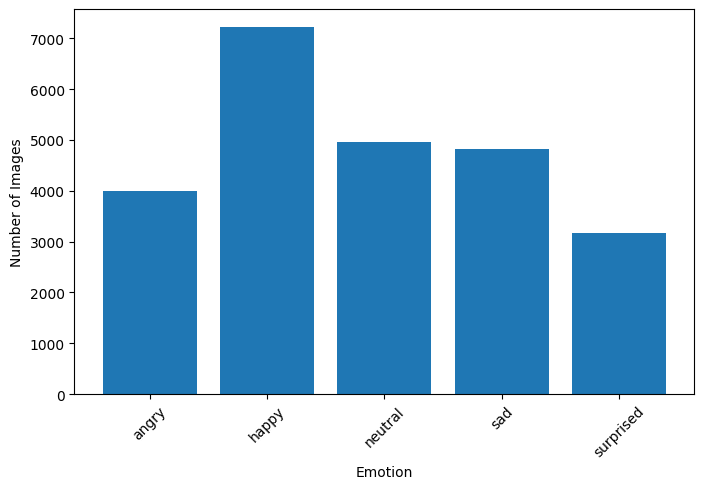

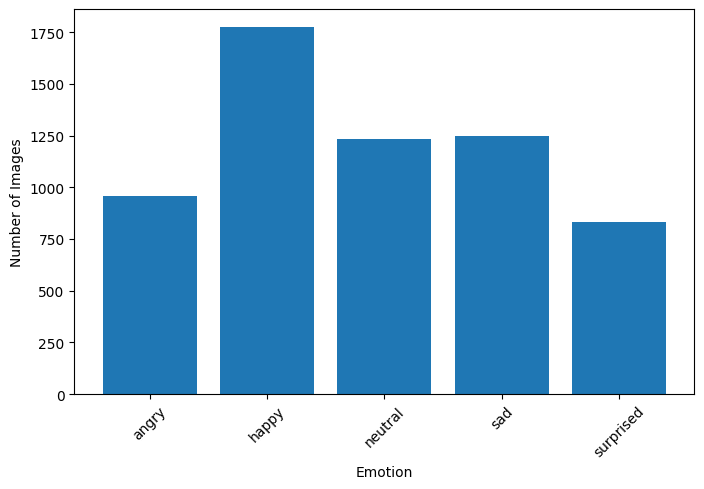

In [6]:
import numpy as np

# Function to plot the counts for each dataset
def plot_image_counts(counts_dict, dataset_name):
    emotions = list(counts_dict.keys())
    counts = list(counts_dict.values())
    
    plt.figure(figsize=(8, 5))
    plt.bar(emotions, counts)
    plt.xlabel("Emotion")
    plt.ylabel("Number of Images")
    # plt.title(f"Number of Images per Emotion {dataset_name}")
    plt.xticks(rotation=45)
    plt.show()

# Plot counts for each dataset
plot_image_counts(original_counts1, "")
plot_image_counts(train1_counts, "Train Dataset 1")
plot_image_counts(test1_counts, "Test Dataset 1")

In [7]:
torch.__version__

'2.5.1+cu124'

Since we will be using dataset 1 to train the initial model, and apply adaptive learning to dataset 2, we can merge the training and testing datasets together

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size (optional)
    transforms.ToTensor()           # Convert images to PyTorch tensors
])

# Load datasets
train_initial_dataset =  datasets.ImageFolder(root=train_dataset1, transform=transform)
test_initial_dataset = datasets.ImageFolder(root=test_dataset1, transform=transform)

train_initial_loader = DataLoader(train_initial_dataset, batch_size=32, shuffle=True)
test_initial_loader = DataLoader(test_initial_dataset, batch_size=32, shuffle=False)

To address the imbalance in data, we can apply class weights to the CrossEntropyLoss

In [9]:
from collections import Counter

# Assuming `train_dataset` is an instance of `ImageFolder` or a similar dataset
labels = [label for _, label in train_initial_dataset]
class_counts = Counter(labels)
print(class_counts)

# Calculate class weights
num_classes = len(class_counts)
print(f"Number of classes: {num_classes}")
class_weights = [1.0 / class_counts[i] for i in range(num_classes)]
print(f"Class weights: {class_weights}")
class_weights = torch.FloatTensor(class_weights).to(device)  # Move to GPU if needed

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


Counter({1: 7215, 2: 4965, 3: 4830, 0: 3995, 4: 3171})
Number of classes: 5
Class weights: [0.00025031289111389235, 0.0001386001386001386, 0.0002014098690835851, 0.00020703933747412008, 0.000315357931251971]


### Step 4: Training on Dataset
Define the training loop to train on train_dataset1.

In [10]:
from torch.optim import Adam
from torchvision import datasets
from torch.utils.data import DataLoader
import os

if device.type == "cuda":
    # Move the model to the GPU
    model = model.to(device)

# Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Training function
def train(model, data_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

checkpoint_path = 'initial_model.pth'

if os.path.exists(checkpoint_path):
    # Load the model checkpoint if it exists
    model.load_state_dict(torch.load(checkpoint_path))
    print("Loaded model checkpoint")   
else:
    train(model, train_initial_loader, criterion, optimizer)
    # print("proceeds to train")

Loaded model checkpoint


C:\Users\chong\AppData\Local\Temp\ipykernel_3868\1165471699.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Once the model has been trained, we can save the model state dictionary, so that we can load it later.

In [11]:
import torch

# Save the model's state dictionary
torch.save(model.state_dict(), "initial_model.pth")

In [ ]:
import torch
import cv2
from torchvision import transforms
from PIL import Image
import numpy as np
from paho.mqtt import client as mqtt_client
import threading  # For running MQTT in parallel
import time

# MQTT configuration
# broker_address = "192.168.86.24"
broker_address = "10.42.0.32"
broker_port = 1883
topic = 'sensor'

# class_labels = test_initial_loader.dataset.classes

# Global variable for sensor data
class_labels = ['angry', 'happy', 'neutral', 'sad', 'surprised']
sensor_data = ["N/A", "N/A", "N/A", "N/A"]  # Default values: [Temperature, Humidity, Distance, Light]

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust based on model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_frame(frame):
    """Predict the class for a given video frame."""
    pil_image = Image.fromarray(frame)  # Convert from OpenCV image to PIL
    input_tensor = transform(pil_image).unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.to('cuda')  # Move to GPU
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
    return class_labels[predicted.item()]

# MQTT connection and subscription
def connect_mqtt():
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connected to MQTT Broker!")
        else:
            print(f"Failed to connect, return code {rc}")

    client = mqtt_client.Client()
    client.on_connect = on_connect
    client.connect(broker_address, broker_port)
    return client

def subscribe(client):
    def on_message(client, userdata, msg):
        global sensor_data
        try:
            message = msg.payload.decode()
            temperature, humidity, distance, light = message.split('+')
            sensor_data = [temperature.strip(), humidity.strip(), distance.strip(), light.strip()]
        except Exception as e:
            print(f"Error processing MQTT message: {e}")
    client.subscribe(topic)
    client.on_message = on_message

# Run MQTT client in a separate thread
def start_mqtt():
    client = connect_mqtt()
    subscribe(client)
    client.loop_forever()

# Start the MQTT client in a separate thread
mqtt_thread = threading.Thread(target=start_mqtt, daemon=True)
mqtt_thread.start()

# Start the camera feed
cap = cv2.VideoCapture(1)  # 0 for default camera

if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

print("Press 'q' to quit.")

is_camera = True

if (is_camera):
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to capture frame.")
            break

        # Convert BGR (OpenCV default) to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Predict the class
        predicted_class = predict_frame(rgb_frame)

        # Overlay prediction, temperature, and humidity on the frame
        cv2.putText(frame, f"Prediction: {predicted_class}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        cv2.putText(frame, f"Temperature: {sensor_data[0]} C", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        cv2.putText(frame, f"Humidity: {sensor_data[1]}%", (10, 90),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        cv2.putText(frame, f"Distance: {sensor_data[2]}cm", (10, 120),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        cv2.putText(frame, f"Light: {sensor_data[3]}/100", (10, 150),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        # Show the frame
        cv2.imshow('Real-time Prediction', frame)

        # Quit if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
else:
    # Load an image instead of capturing from the camera
    image_path = "test.jpg"  # Replace with the path to your image
    frame = cv2.imread(image_path)  # Load the image

    if frame is None:
        print("Error: Could not load image.")
        exit()

    # Convert BGR (OpenCV default) to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Predict the class
    predicted_class = predict_frame(rgb_frame)

    while True:
        # Display the image with the overlays
        # cv2.imshow('Image Prediction', frame)
        print(f"Prediction: {predicted_class}")
        print(f"Temperature: {sensor_data[0]} C")
        print(f"Humidity: {sensor_data[1]}%")
        time.sleep(2.0)
        # Check if the window is still open
        # if cv2.getWindowProperty('Image Prediction', cv2.WND_PROP_VISIBLE) < 1:
        #     break

# Release the camera and close the window
cap.release()
cv2.destroyAllWindows()


C:\Users\chong\AppData\Local\Temp\ipykernel_3868\1545321546.py:47: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt_client.Client()


Connected to MQTT Broker!
Press 'q' to quit.
Connected to MQTT Broker!
